In [114]:
from io import BytesIO
from zipfile import ZipFile
import requests, zipfile
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# Question 1: Load
* Structure: there are 641914 records, and 29 columns. Among the 29 columns, 3 are boolean, 4 are date time, 9 are float, 6 are integer, and 7 are categorical
* Assumption: empty string in a field means it is missing value

## Download data

In [2]:
def download_zip_from_url(zip_file_url):
    '''
    Downloads zipped data from given url and returns a zip file object
    Input: Url of data source
    Output: zipped file object
    ''' 
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    return z 

In [3]:
# Step 1: download data
#z = download_zip_from_url('https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip')

# Step 2: extract data
#z.extractall()

# Step 3: read data and display column names
#filename = z.namelist()[0]
filename = 'transactions.txt'
data = pd.read_json(filename, lines = True)
print(data.columns)

Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'availableMoney',
       'cardCVV', 'cardLast4Digits', 'cardPresent', 'creditLimit',
       'currentBalance', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'echoBuffer', 'enteredCVV',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCity', 'merchantCountryCode', 'merchantName', 'merchantState',
       'merchantZip', 'posConditionCode', 'posEntryMode', 'posOnPremises',
       'recurringAuthInd', 'transactionAmount', 'transactionDateTime',
       'transactionType'],
      dtype='object')


In [4]:
# Step 4: sort the data according to account number and transaction time
data = data.sort_values(by = ['accountNumber', 'transactionDateTime'])

# Step 5: check a sample of data 
data.head(10)

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,customerId,dateOfLastAddressChange,echoBuffer,enteredCVV,expirationDateKeyInMatch,isFraud,merchantCategoryCode,merchantCity,merchantCountryCode,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType
583485,100547107,2011-10-30,US,2500.00,786,1222,True,2500,0.00,02/2030,100547107,2011-10-30,,786,False,False,fastfood,,US,Popeyes #414406,,,01,09,,,64.66,2016-01-02T01:47:46,PURCHASE
583486,100547107,2011-10-30,US,2435.34,786,1222,True,2500,64.66,01/2023,100547107,2011-10-30,,786,False,False,fastfood,,US,Popeyes #700785,,,01,80,,,5.31,2016-01-16T23:35:41,PURCHASE
583487,100547107,2011-10-30,US,2430.03,786,1222,True,2500,69.97,06/2029,100547107,2011-10-30,,786,False,False,fastfood,,US,Arbys #46046,,,01,02,,,204.23,2016-01-17T21:50:04,PURCHASE
583488,100547107,2011-10-30,US,2225.80,786,1222,True,2500,274.20,12/2020,100547107,2011-10-30,,786,False,False,fastfood,,US,Shake Shack #968081,,,08,05,,,155.28,2016-01-29T05:19:50,PURCHASE
583489,100547107,2011-10-30,US,2070.52,786,1222,True,2500,429.48,01/2027,100547107,2011-10-30,,786,False,False,fastfood,,US,In-N-Out #27394,,,01,09,,,91.14,2016-01-30T20:49:10,PURCHASE
583490,100547107,2011-10-30,US,2500.00,786,1222,True,2500,0.00,02/2022,100547107,2011-10-30,,786,False,False,fastfood,,US,Quizno's #205329,,,01,02,,,2.80,2016-02-06T22:31:44,PURCHASE
583491,100547107,2011-10-30,US,2497.20,786,1222,True,2500,2.80,07/2024,100547107,2011-10-30,,786,False,False,fastfood,,US,Domino's Pizza #962710,,,01,05,,,119.77,2016-02-10T06:48:23,PURCHASE
583492,100547107,2011-10-30,US,2377.43,786,1222,True,2500,122.57,01/2027,100547107,2011-10-30,,786,False,False,fastfood,,US,Domino's Pizza #660134,,,01,05,,,211.11,2016-02-11T08:28:07,PURCHASE
583493,100547107,2011-10-30,US,2166.32,786,1222,True,2500,333.68,04/2026,100547107,2011-10-30,,786,False,False,fastfood,,US,Krispy Kreme #122012,,,01,09,,,66.23,2016-02-20T01:01:47,PURCHASE
583494,100547107,2011-10-30,US,2100.09,786,1222,True,2500,399.91,03/2022,100547107,2011-10-30,,786,False,False,fastfood,,US,Wendys #327348,,,01,02,,,1.06,2016-02-26T04:02:55,PURCHASE


In [5]:
# Step 6: change date time variable to appropriate data type
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
data['accountOpenDate'] = pd.to_datetime(data['accountOpenDate'])
data['currentExpDate'] = pd.to_datetime(data['currentExpDate'])
data['dateOfLastAddressChange'] = pd.to_datetime(data['dateOfLastAddressChange'])

# Step 7: notice from the sample data above that missing values are present as empty string
data = data.replace('', np.nan)

# Step 8: check structure of data
print('There are', data.shape[0], 'rows and', data.shape[1], 'columns.')

There are 641914 rows and 29 columns.


## Basic summary statistics

### Missing value counts for each column

In [6]:
# Step 9: check missing values in each column
data.isnull().sum(axis = 0)

accountNumber                    0
accountOpenDate                  0
acqCountry                    3913
availableMoney                   0
cardCVV                          0
cardLast4Digits                  0
cardPresent                      0
creditLimit                      0
currentBalance                   0
currentExpDate                   0
customerId                       0
dateOfLastAddressChange          0
echoBuffer                  641914
enteredCVV                       0
expirationDateKeyInMatch         0
isFraud                          0
merchantCategoryCode             0
merchantCity                641914
merchantCountryCode            624
merchantName                     0
merchantState               641914
merchantZip                 641914
posConditionCode               287
posEntryMode                  3345
posOnPremises               641914
recurringAuthInd            641914
transactionAmount                0
transactionDateTime              0
transactionType     

### Data type for each column

In [7]:
# Step 10: check data type and number of non-null values for each column
print(data.info())

# Columns with 0 non-null values are present, drop these columns where all values are missing
data = data.dropna(axis = 'columns', how = 'all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641914 entries, 583485 to 171056
Data columns (total 29 columns):
accountNumber               641914 non-null int64
accountOpenDate             641914 non-null datetime64[ns]
acqCountry                  638001 non-null object
availableMoney              641914 non-null float64
cardCVV                     641914 non-null int64
cardLast4Digits             641914 non-null int64
cardPresent                 641914 non-null bool
creditLimit                 641914 non-null int64
currentBalance              641914 non-null float64
currentExpDate              641914 non-null datetime64[ns]
customerId                  641914 non-null int64
dateOfLastAddressChange     641914 non-null datetime64[ns]
echoBuffer                  0 non-null float64
enteredCVV                  641914 non-null int64
expirationDateKeyInMatch    641914 non-null bool
isFraud                     641914 non-null bool
merchantCategoryCode        641914 non-null object
merchan

### Numeric variables distribution

In [8]:
# Step 11: check average, standard deviation, min, median, and maximum values for appropriate numeric columns
numerics = ['availableMoney', 'creditLimit', 'currentBalance', 'transactionAmount']
data[numerics].describe()

,availableMoney,creditLimit,currentBalance,transactionAmount
count,641914.000000,641914.000000,641914.000000,641914.000000
mean,6652.828573,10697.210608,4044.382035,135.162497
std,9227.132275,11460.359133,5945.510224,147.053302
min,-1244.930000,250.000000,0.000000,0.000000
25%,1114.970000,5000.000000,502.442500,32.320000
50%,3578.165000,7500.000000,2151.860000,85.800000
75%,8169.185000,15000.000000,5005.890000,189.030000
max,50000.000000,50000.000000,47496.500000,1825.250000


### Datetime variables distribution

In [9]:
# Step 12: check time span for date time columns
data.describe(include = ['datetime64'])

,accountOpenDate,currentExpDate,dateOfLastAddressChange,transactionDateTime
count,641914,641914,641914,641914
unique,1826,165,2186,635472
top,2015-12-11 00:00:00,2026-05-01 00:00:00,2016-07-20 00:00:00,2016-02-13 12:23:26
freq,10137,4209,3948,3
first,1985-12-25 00:00:00,2018-05-01 00:00:00,1985-12-25 00:00:00,2016-01-01 00:00:37
last,2015-12-31 00:00:00,2032-01-01 00:00:00,2016-12-30 00:00:00,2016-12-30 23:59:27


### Categorical variables distribution

In [10]:
# Step 13: check unique values and most-frequent value for categorical variables
data.describe(include = ['object'])

,acqCountry,merchantCategoryCode,merchantCountryCode,merchantName,posConditionCode,posEntryMode,transactionType
count,638001,641914,641290,641914,641627,638569,641325
unique,4,19,4,2493,3,5,3
top,US,online_retail,US,Lyft,01,05,PURCHASE
freq,632303,161469,635577,25311,514144,255615,608685


In [11]:
# Step 14: check frequency of each unique value for categorical variables
categoricals = [x for x in data.columns if data[x].dtypes == np.object]

for var in categoricals:
    num_unique_values = data[var].nunique()
    
    print(var, 'has', num_unique_values, 'unique values.')
    if num_unique_values < 10:
        print(data[var].value_counts())
    print()

acqCountry has 4 unique values.
US     632303
MEX      2626
CAN      1870
PR       1202
Name: acqCountry, dtype: int64

merchantCategoryCode has 19 unique values.

merchantCountryCode has 4 unique values.
US     635577
MEX      2636
CAN      1874
PR       1203
Name: merchantCountryCode, dtype: int64

merchantName has 2493 unique values.

posConditionCode has 3 unique values.
01    514144
08    121507
99      5976
Name: posConditionCode, dtype: int64

posEntryMode has 5 unique values.
05    255615
09    193193
02    160589
90     16251
80     12921
Name: posEntryMode, dtype: int64

transactionType has 3 unique values.
PURCHASE                608685
ADDRESS_VERIFICATION     16478
REVERSAL                 16162
Name: transactionType, dtype: int64



# Question 2: Plot 
Findings:
* Transaction amount is right-skewed, with large value outliers. However, about 80% of transactions have a value of below 250 dollars
* Removing the top 2.5% and bottom 2.5% of transaction amount does not change the distribution of data dramatically

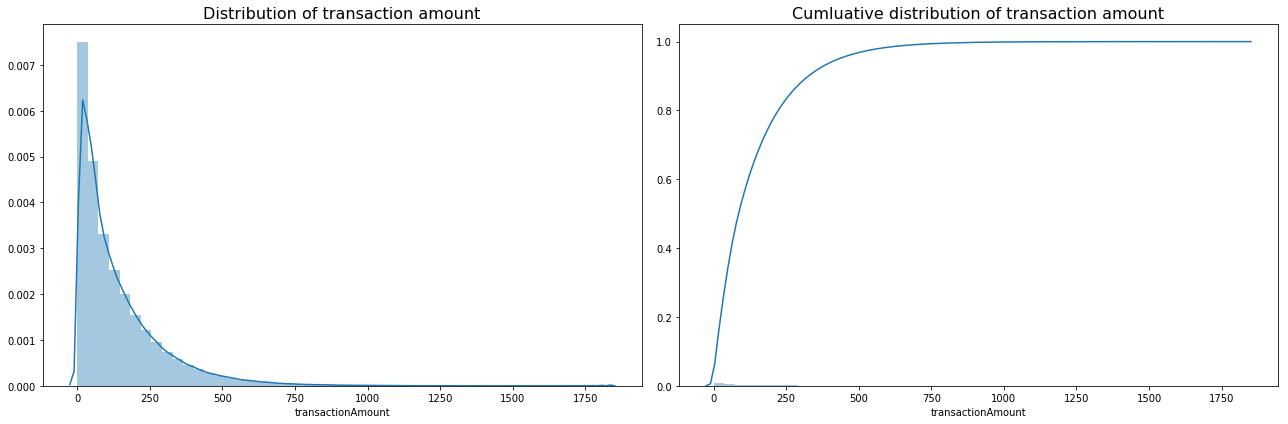

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(data['transactionAmount'] ,ax = ax[0])
ax[0].set_title('Distribution of transaction amount', fontsize = 16)

sns.distplot(data['transactionAmount'] ,kde_kws=dict(cumulative=True), ax = ax[1])
ax[1].set_title('Cumluative distribution of transaction amount', fontsize = 16)

plt.tight_layout()
plt.show()

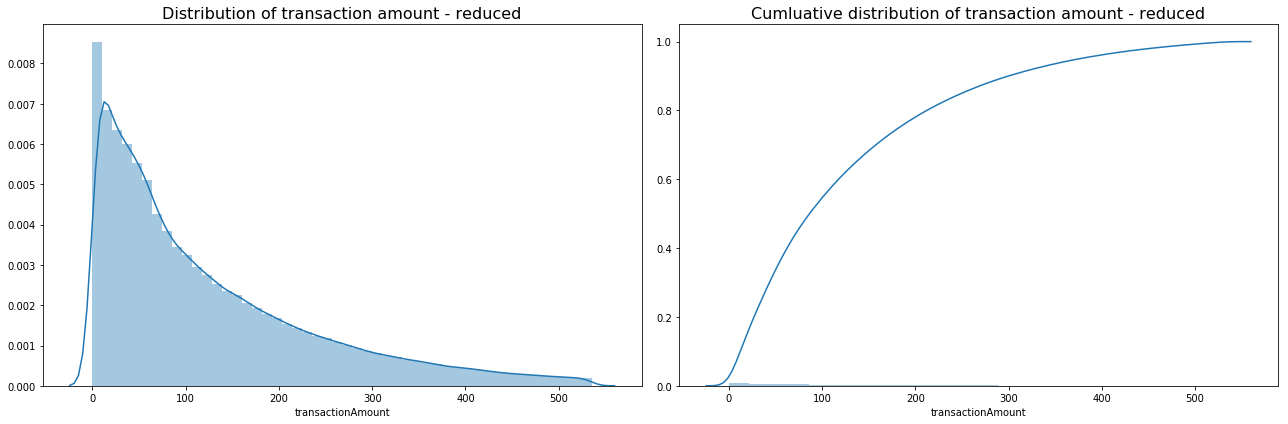

In [13]:
# Exclude top 2.5% and bottom 2.5% of the data to remove any potential outliers
data_reduced = data[(data['transactionAmount'] < data['transactionAmount'].quantile(.975)) & (data['transactionAmount'] > data['transactionAmount'].quantile(0.025))]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(data_reduced['transactionAmount'] ,ax = ax[0])
ax[0].set_title('Distribution of transaction amount - reduced', fontsize = 16)

sns.distplot(data_reduced['transactionAmount'] ,kde_kws=dict(cumulative=True), ax = ax[1])
ax[1].set_title('Cumluative distribution of transaction amount - reduced', fontsize = 16)

plt.tight_layout()
plt.show()

# Question 3: Data Wrangling - Duplicates Transactions
Definitions:
1.  **Reversed transactions** are those with a transaction type "REVERSAL"
2. **Multiple-swipe transactions** are transactions performed by same consumer, using the same card at the same merchant with same transaction amount and done more than once within 10 minutes

Findings:
1. There are 16162 transactions being marked as reversed transactions, or equivalently, 2.5% of all transactions. The total dollar amount of reversed transactions is \$2,242,915.1, which is 2.6% of all transactions.
2. Compared to non-reversed transactions, reversed transactions have higher average and median transaction dollar  amount
3. Card acquired at the US and accommodation and transportation expenses are more likely to be reversed transactions
4. There are 10598 transactions being marked as multipe swipe transactions, or equivalently, 1.7% of all transactions. The total dollar amount of multiple swipe transactions is \$1,540,642.54 which is 1.8% of all transactions.
5. Compared to non-multiple-swipe transactions, multiple-swipe transactions have higher average and median transaction dollar amount
6. Card acquired and transactions performed in Purto Rico are more likely to experience multiple swipe

### Reversed transactions

In [14]:
# Step 1: Reversed transactions identification
data['reversed'] = 0
data.loc[(data['transactionType'] == 'REVERSAL'), 'reversed'] = 1

num_reversed = data.loc[data['reversed'] == 1].shape[0]
dollar_amount_reversed = data.loc[data['reversed'] == 1]['transactionAmount'].sum()

print('There are', num_reversed, 'transactions being marked as reversed transactions, or equivalently,', \
      str(round(num_reversed/data.shape[0]*100, 1)) + '% of all transactions. \
      The total dollar amount of reversed transactions is', round(dollar_amount_reversed, 2), \
     'which is', str(round(dollar_amount_reversed
                           /data['transactionAmount'].sum()*100, 1)) + '% of all transactions.')

There are 16162 transactions being marked as reversed transactions, or equivalently, 2.5% of all transactions.       The total dollar amount of reversed transactions is 2242915.1 which is 2.6% of all transactions.


In [15]:
# Step 2: check average, standard deviation, min, median, and maximum values for appropriate numeric columns
numerics = ['availableMoney', 'creditLimit', 'currentBalance', 'transactionAmount']
data.groupby(['reversed'])[numerics].agg(['mean', 'median'])

availableMoney             creditLimit        currentBalance  \
                   mean    median          mean median           mean   
reversed                                                                
0           6658.459930  3583.485  10693.722114   7500    4035.262184   
1           6434.796593  3389.365  10832.276327   7500    4397.479735   

                   transactionAmount         
            median              mean median  
reversed                                     
0         2144.730        135.069139  85.63  
1         2419.695        138.777076  91.28

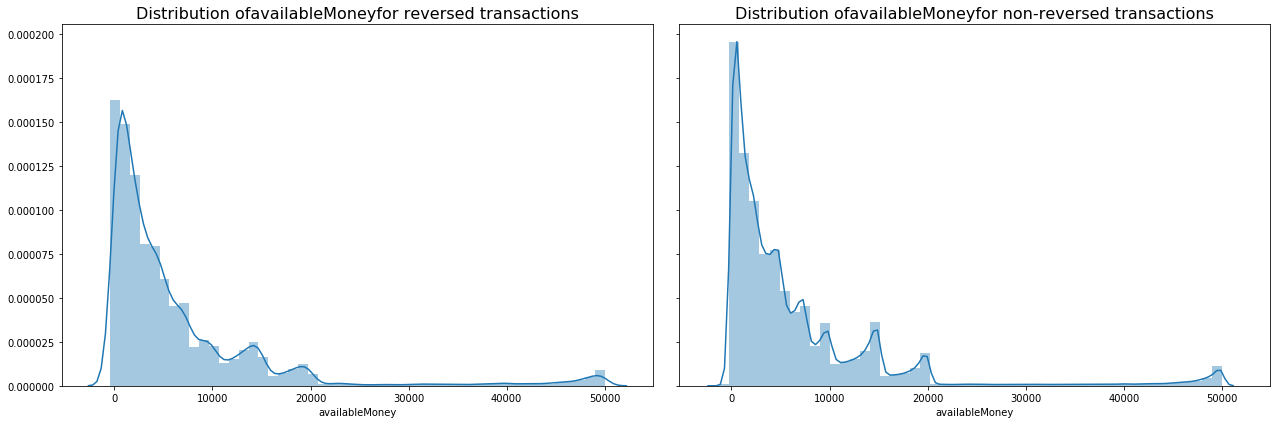

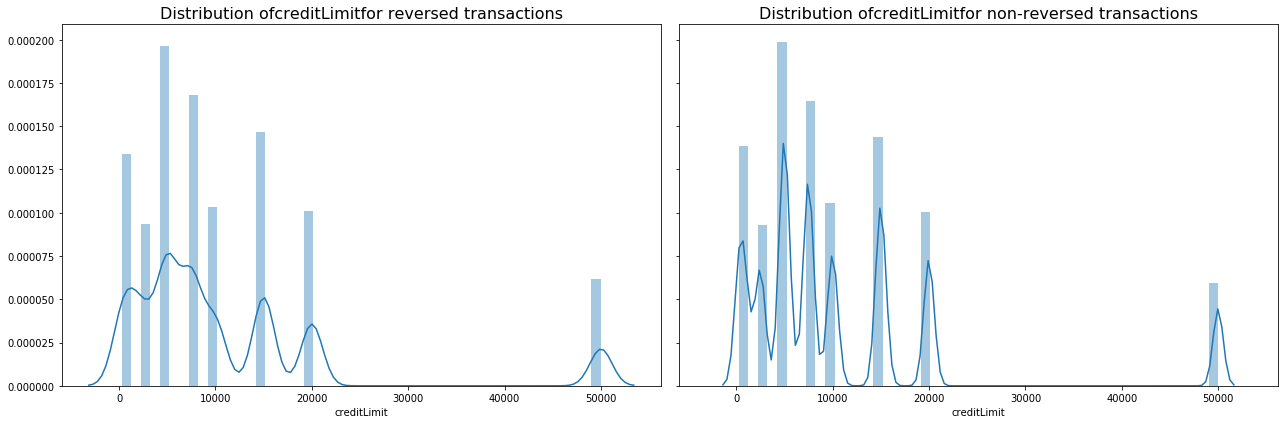

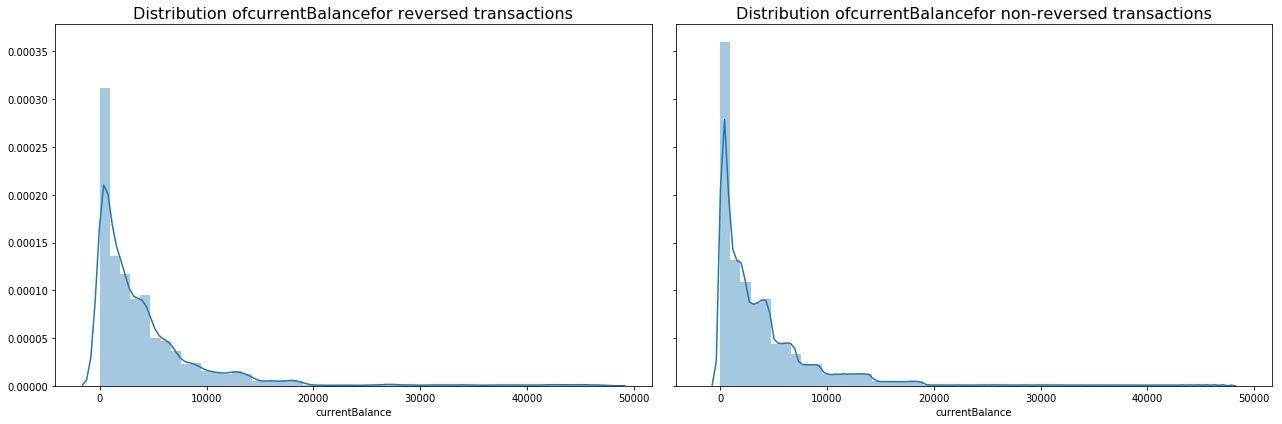

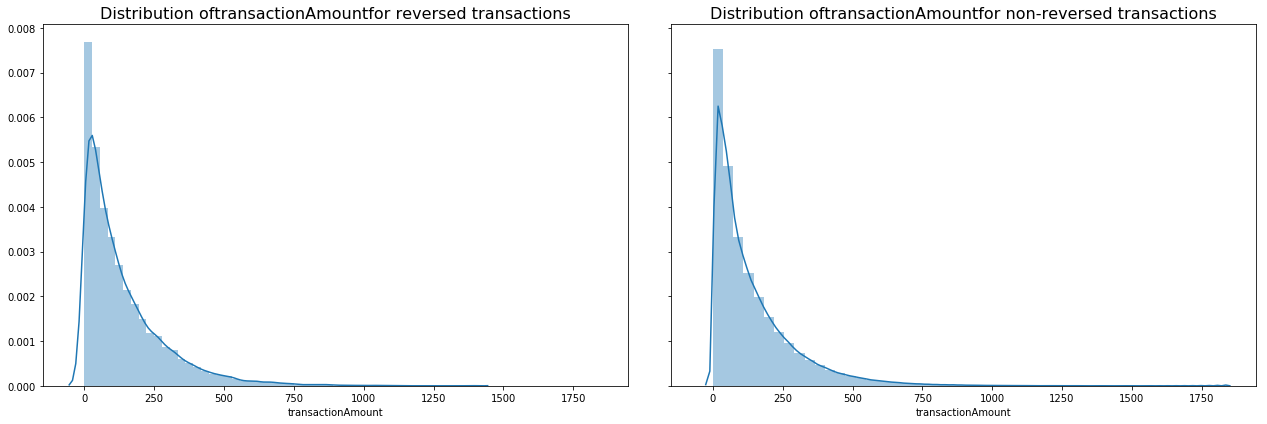

In [16]:
# Step 3: check visualzied distribution for reversed vs non-reversed transactions
for var in numerics:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey = True, sharex = True)

    sns.distplot(data[data['reversed']==1][var] ,ax = ax[0])
    plot_title = 'Distribution of' + var + 'for reversed transactions'
    ax[0].set_title(plot_title, fontsize = 16)
    
    sns.distplot(data[data['reversed']==0][var] ,ax = ax[1])
    plot_title = 'Distribution of' + var + 'for non-reversed transactions'
    ax[1].set_title(plot_title, fontsize = 16)

    plt.tight_layout()
    plt.show()

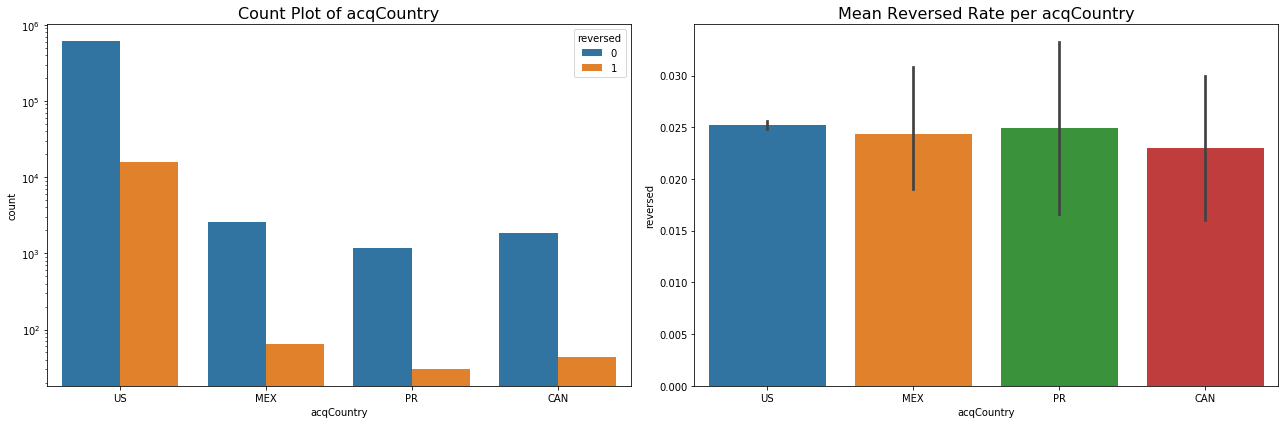

  acqCountry  reversed rate
3         US       0.025205
2         PR       0.024958
1        MEX       0.024372
0        CAN       0.022995



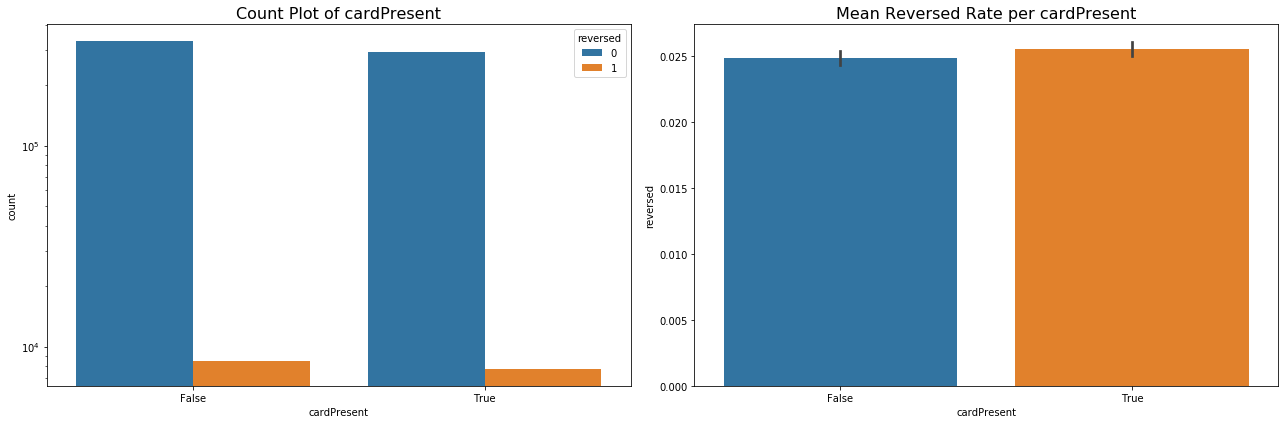

   cardPresent  reversed rate
1         True       0.025539
0        False       0.024858



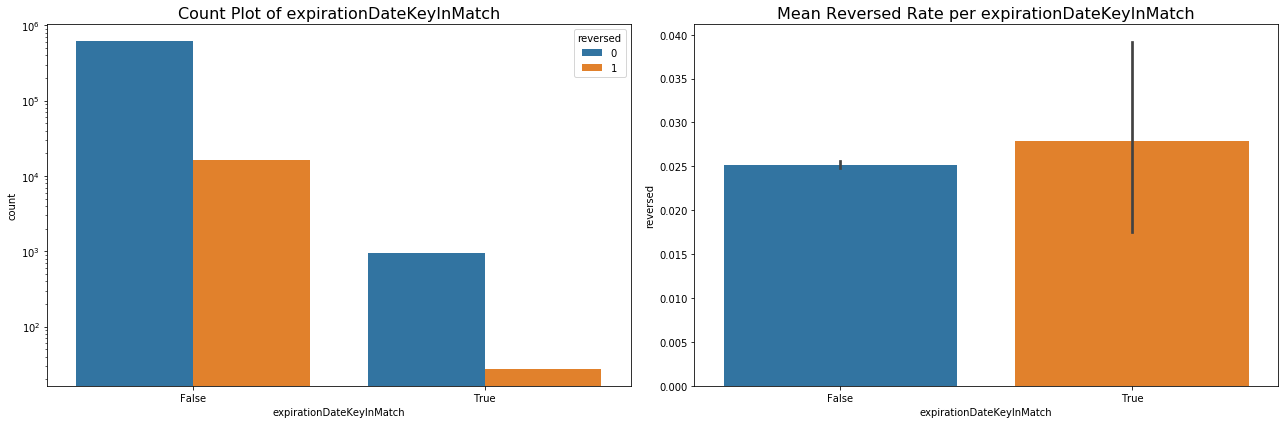

   expirationDateKeyInMatch  reversed rate
1                      True       0.027864
0                     False       0.025174



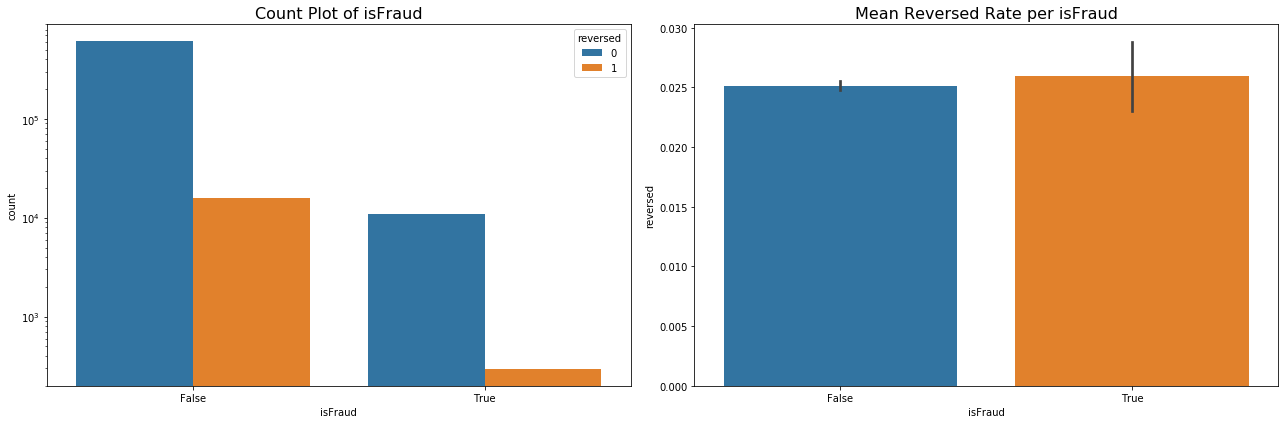

   isFraud  reversed rate
1     True       0.025925
0    False       0.025164

   merchantCategoryCode  reversed rate
0               airline       0.029429
11               hotels       0.028673
1                  auto       0.028580
10               health       0.028235
13         online_gifts       0.028143
3         entertainment       0.027872
17            rideshare       0.027643
14        online_retail       0.027621
16        personal care       0.027546
4              fastfood       0.027511



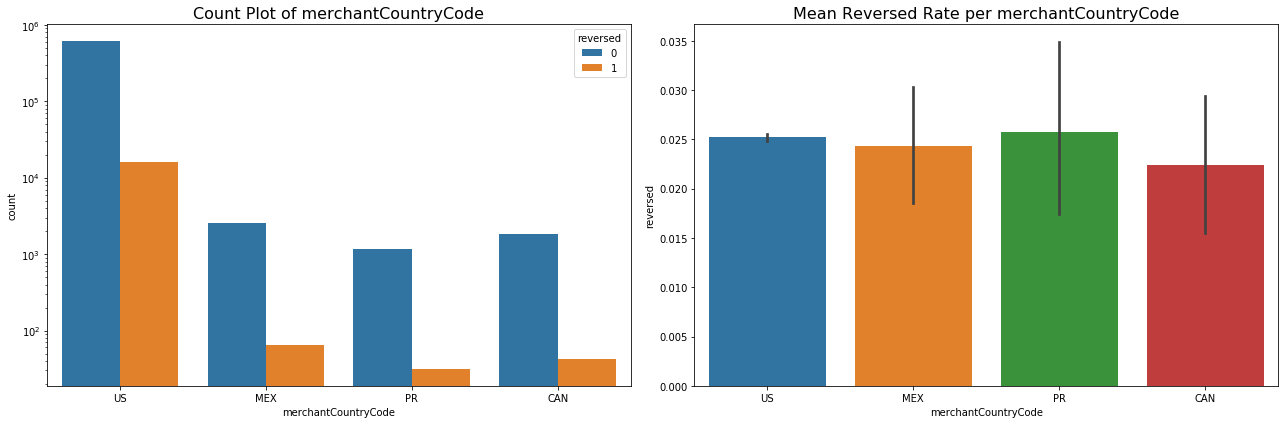

  merchantCountryCode  reversed rate
2                  PR       0.025769
3                  US       0.025196
1                 MEX       0.024279
0                 CAN       0.022412

              merchantName  reversed rate
2181           WSC #392958       0.142857
2170           WSC #264919       0.136364
1173          NYSC #601170       0.125000
2341     Walgreens #951810       0.120000
1393  Powerlifting #293339       0.115385
2279     Walgreens #348717       0.115385
2208           WSC #612041       0.115385
2199           WSC #502956       0.111111
1426  Powerlifting #675142       0.111111
669      Golds Gym #837214       0.111111



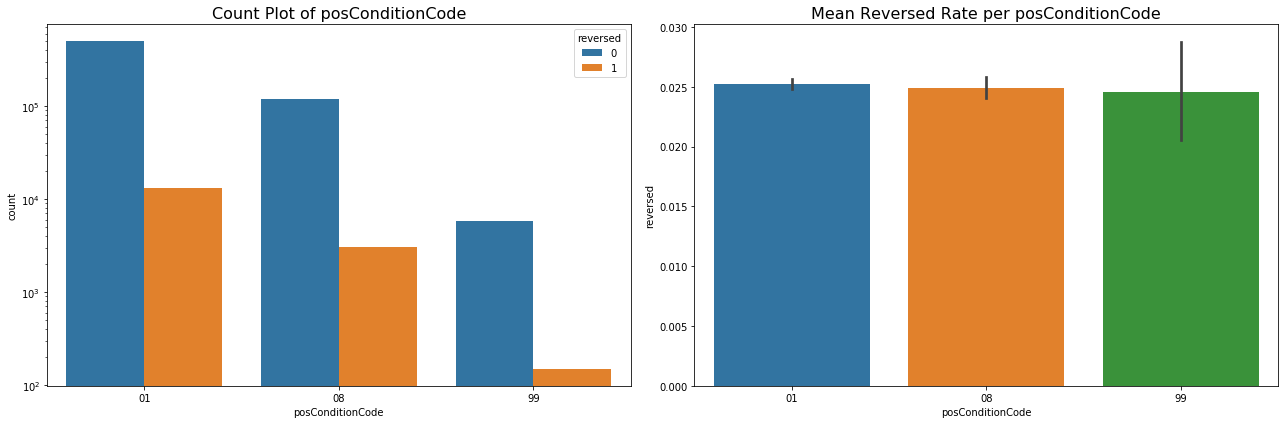

  posConditionCode  reversed rate
0               01       0.025248
1               08       0.024929
2               99       0.024598

  posEntryMode  reversed rate
3           80       0.025385
1           05       0.025319
2           09       0.025229
0           02       0.025058
4           90       0.023752

        merchantName_mod  reversed rate
113      Northtown Salon       0.047619
70             Fast Tire       0.045738
182     West End Massage       0.043137
188  ashleyfurniture.com       0.042751
6            34th Bistro       0.039113
88         John's Bistro       0.037086
178          Wayfair.com       0.036885
59           Duane Reed        0.035714
3         1st Restaurant       0.035433
29        Bobs Furniture       0.035019



In [37]:
# Step 4: Visualizations of reversal rate by categorical and boolean variables

# Create modified merchant name that only contains the store name, but no branch information
data['merchantName_mod'] = data['merchantName'].str.split('#').str[0]

categoricals = [x for x in data.columns if data[x].dtypes in (np.object, np.bool) and x != 'transactionType']

for var in categoricals:
    num_unique_values = data[var].nunique()
    
    if num_unique_values  < 5:
        

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
        sns.countplot(x=var, hue='reversed', data=data, ax=ax[0])
        plot_title = 'Count Plot of ' + str(var)
        ax[0].set_title(plot_title, fontsize=16)
        ax[0].set_yscale('log')
        
        sns.barplot(x = var, y='reversed', data=data, ax=ax[1])
        plot_title = 'Mean Reversed Rate per '  + str(var)
        ax[1].set_title(plot_title, fontsize=16)
        plt.tight_layout()
        plt.show()
        
        grouped = data[[var, 'reversed']].groupby(var).mean().reset_index()
        grouped.rename(columns = {'reversed': 'reversed rate'}, inplace = True)
        print(grouped.sort_values(by = 'reversed rate', ascending=False))
        print()
    else:
        grouped = data[[var, 'reversed']].groupby(var).mean().reset_index()
        grouped.rename(columns = {'reversed': 'reversed rate'}, inplace = True)
        print(grouped.sort_values(by = 'reversed rate', ascending=False).head(10))
        print()

### Multiple swipe transactions

In [18]:
# Step 1: multiple swipe transactions identification
data = data.sort_values(by = ['accountNumber', 'customerId', 'merchantName', 'transactionAmount', 'transactionDateTime'])
data['time_diff'] = data.groupby(['accountNumber', 'customerId', 'merchantName', 'transactionAmount'], as_index=False)['transactionDateTime'].transform(lambda x: x- x.iloc[0]) 

data['multiSwipe'] = 0
data.loc[(data['time_diff'] > datetime.timedelta(minutes = 0))
         & (data['time_diff'] < datetime.timedelta(minutes = 10)), 'multiSwipe'] = 1

num_multi = data.loc[data['multiSwipe'] == 1].shape[0]
dollar_amount_multi = data.loc[data['multiSwipe'] == 1]['transactionAmount'].sum()

print('There are', num_multi, 'transactions being marked as multipe swipe transactions, or equivalently,', \
      str(round(num_multi/data.shape[0]*100, 1)) + '% of all transactions. \
      The total dollar amount of multiple swipe transactions is', dollar_amount_multi, \
     'which is', str(round(dollar_amount_multi
                           /data['transactionAmount'].sum()*100, 1)) + '% of all transactions.')

There are 10598 transactions being marked as multipe swipe transactions, or equivalently, 1.7% of all transactions.       The total dollar amount of multiple swipe transactions is 1540642.54 which is 1.8% of all transactions.


In [19]:
# Step 2: check average, standard deviation, min, median, and maximum values for appropriate numeric columns
numerics = ['availableMoney', 'creditLimit', 'currentBalance', 'transactionAmount']
data.groupby(['multiSwipe'])[numerics].agg(['mean', 'median'])

availableMoney            creditLimit        currentBalance  \
                     mean   median          mean median           mean   
multiSwipe                                                               
0             6655.960013  3579.86  10694.761815   7500    4038.801802   
1             6466.290698  3483.56  10843.083601   7500    4376.792902   

                    transactionAmount         
             median              mean median  
multiSwipe                                    
0           2149.36        134.991124  85.52  
1           2307.18        145.371064  99.79

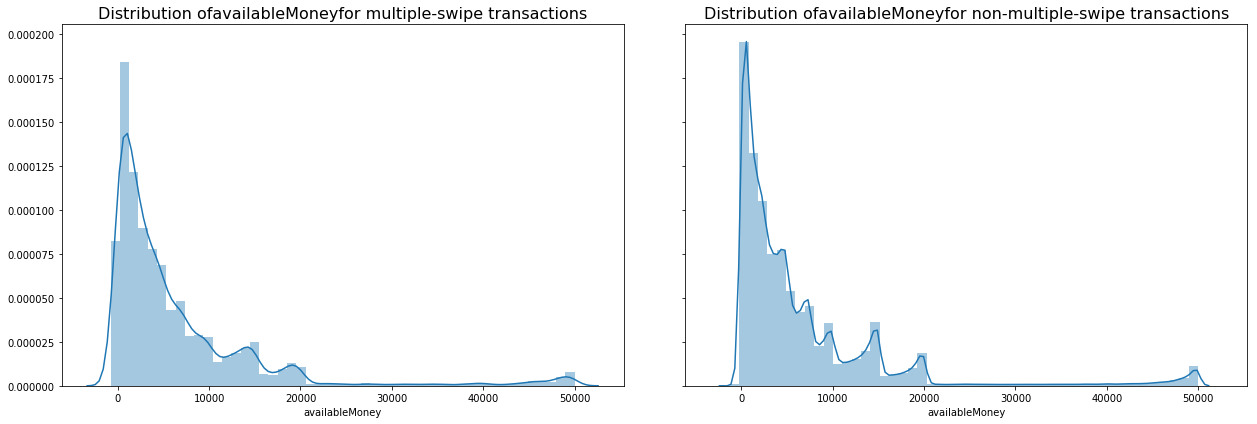

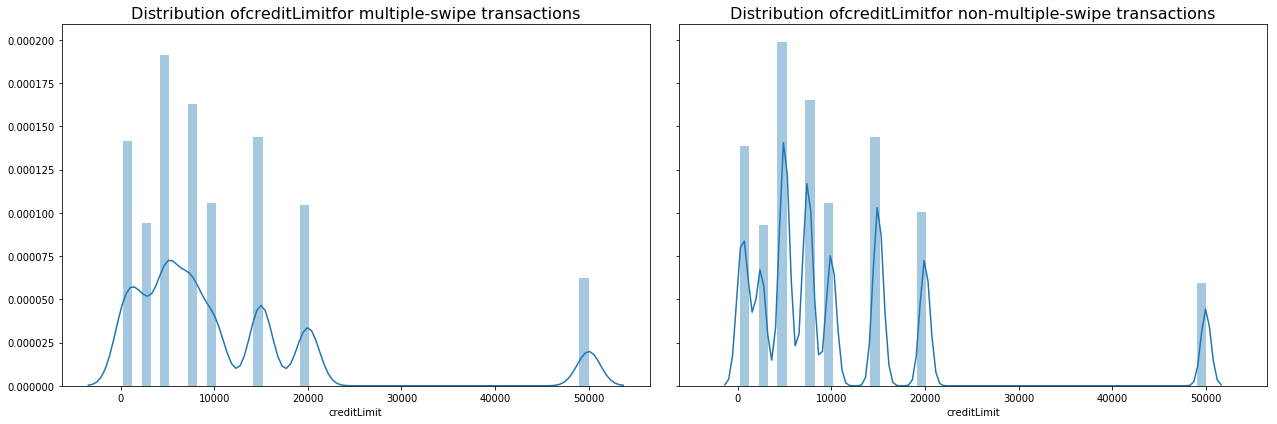

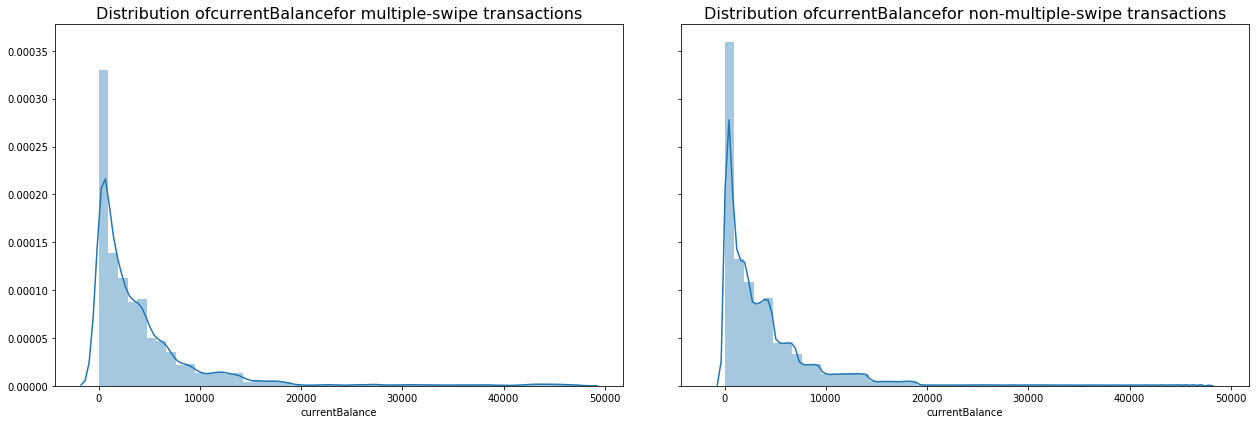

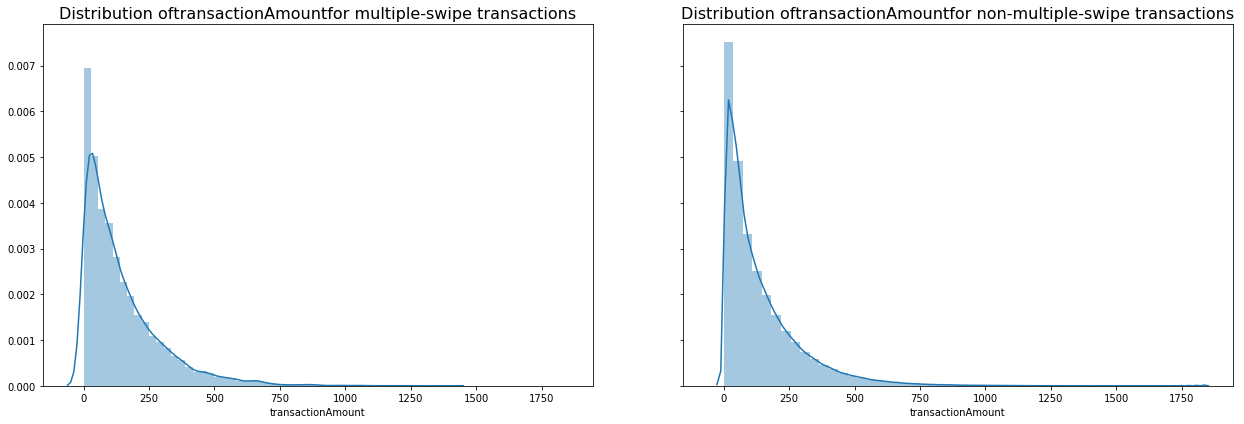

In [20]:
# Step 3: check visualzied distribution for multiple-swipe vs non-multiple-swipe transactions
for var in numerics:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey = True, sharex = True)

    sns.distplot(data[data['multiSwipe']==1][var] ,ax = ax[0])
    plot_title = 'Distribution of' + var + 'for multiple-swipe transactions'
    ax[0].set_title(plot_title, fontsize = 16)
    
    sns.distplot(data[data['multiSwipe']==0][var] ,ax = ax[1])
    plot_title = 'Distribution of' + var + 'for non-multiple-swipe transactions'
    ax[1].set_title(plot_title, fontsize = 16)

    plt.tight_layout()
    plt.show()

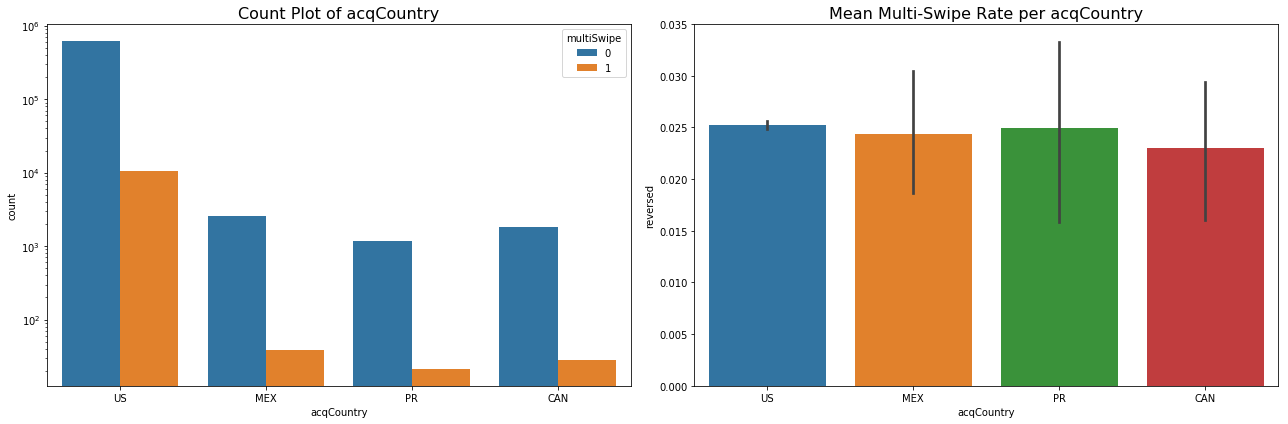

  acqCountry  multiple swipe rate
2         PR             0.017471
3         US             0.016519
0        CAN             0.014973
1        MEX             0.014851



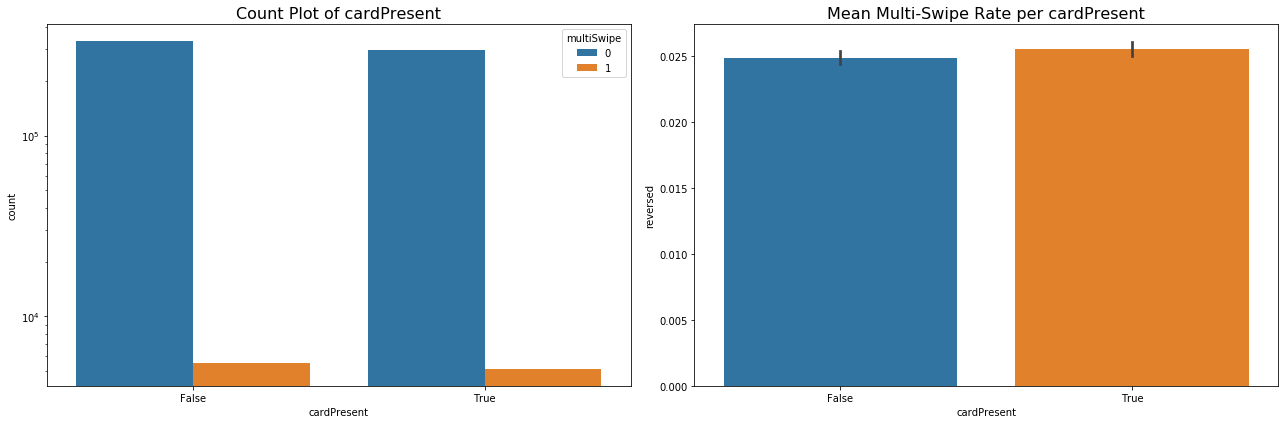

   cardPresent  multiple swipe rate
1         True             0.016855
0        False             0.016205



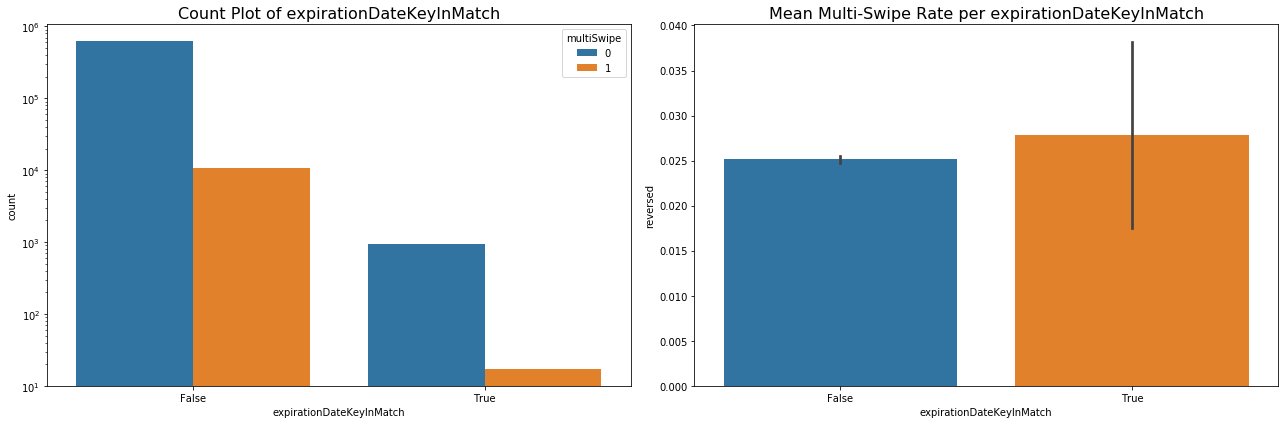

   expirationDateKeyInMatch  multiple swipe rate
1                      True             0.017544
0                     False             0.016508



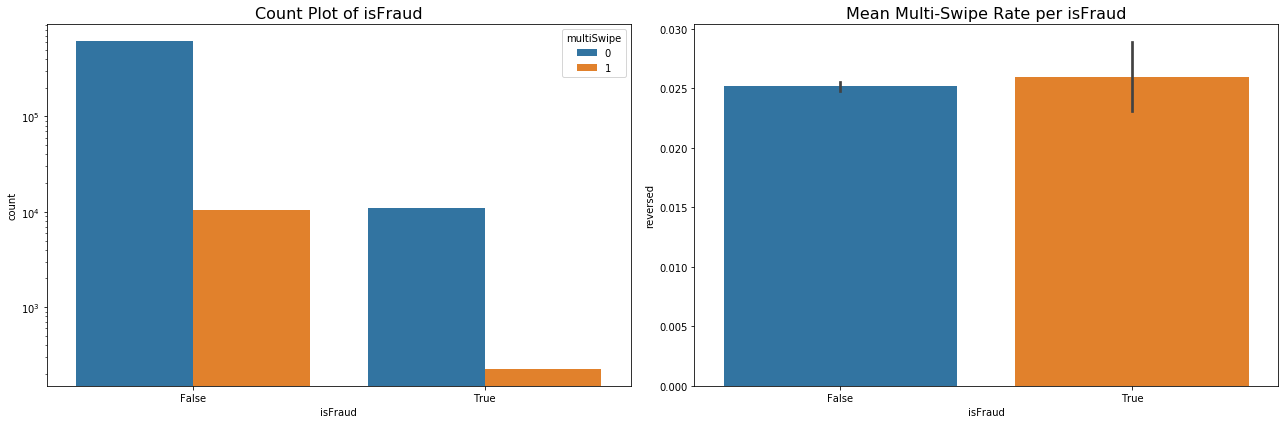

   isFraud  multiple swipe rate
1     True             0.019731
0    False             0.016452

   merchantCategoryCode  multiple swipe rate
0               airline             0.019219
8             furniture             0.019071
16        personal care             0.018975
1                  auto             0.018922
17            rideshare             0.018685
13         online_gifts             0.018369
3         entertainment             0.018253
11               hotels             0.018139
10               health             0.018056
4              fastfood             0.017985



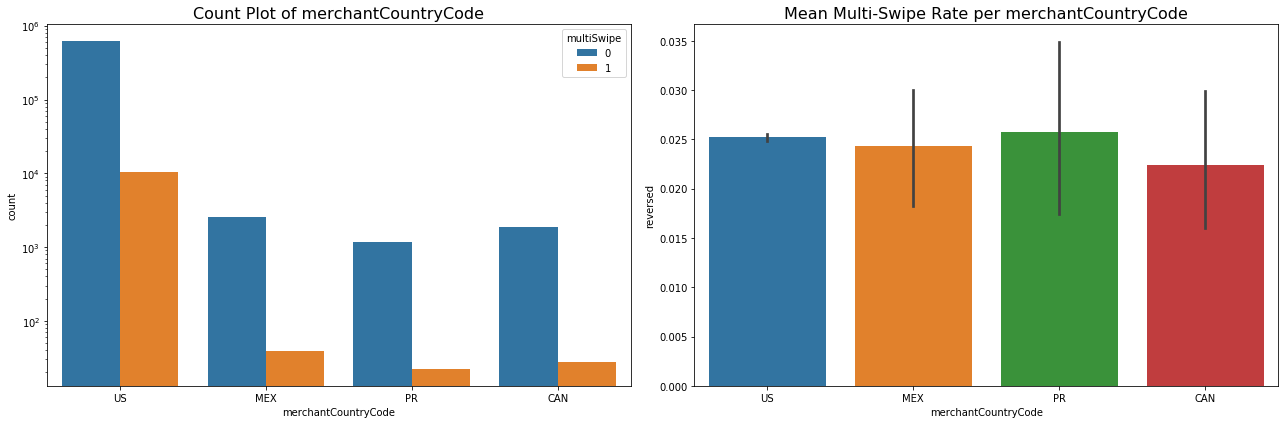

  merchantCountryCode  multiple swipe rate
2                  PR             0.018288
3                  US             0.016522
0                 CAN             0.014941
1                 MEX             0.014795

             merchantName  multiple swipe rate
1391  Powerlifting #26445             0.147059
2322    Walgreens #811259             0.129032
663     Golds Gym #747766             0.121212
271           CVS #618160             0.120000
2272    Walgreens #315691             0.107143
2299    Walgreens #555944             0.105263
1190         NYSC #832595             0.104167
666     Golds Gym #767313             0.100000
2324    Walgreens #842549             0.096774
616     Golds Gym #185635             0.095238



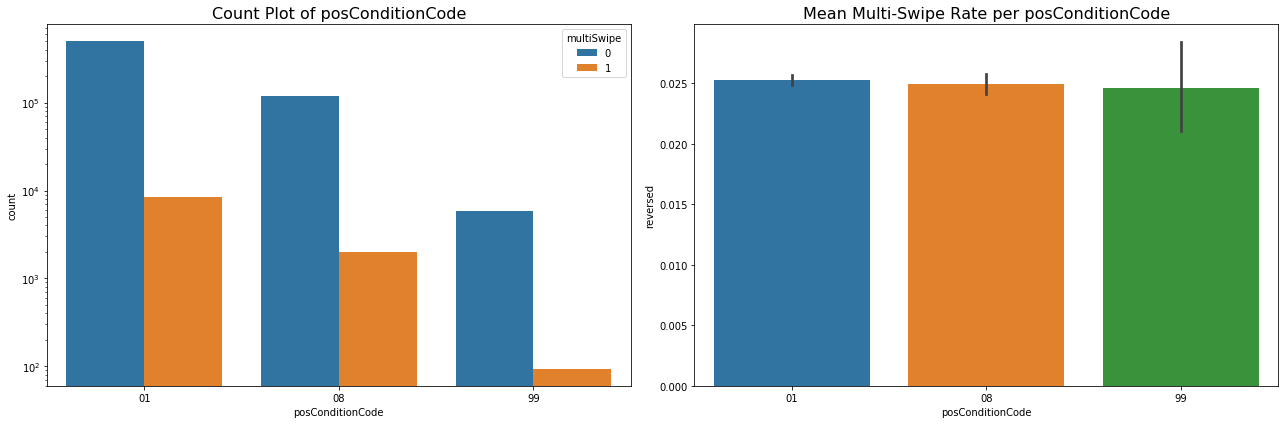

  posConditionCode  multiple swipe rate
0               01             0.016550
1               08             0.016402
2               99             0.015395

  posEntryMode  multiple swipe rate
4           90             0.016676
1           05             0.016599
2           09             0.016533
0           02             0.016464
3           80             0.015866

             merchantName_mod  multiple swipe rate
95            Marriott Hotels             0.055046
63             Eazy Auto Body             0.043568
84                Holiday Inn             0.033613
15                      Aloft             0.031579
182          West End Massage             0.031373
12               86th Massage             0.030702
58     Downtown Sandwitch Bar             0.030303
31              Boston Bistro             0.028834
93           Los Angeles News             0.028740
40   Convenient Auto Services             0.028681



In [38]:
# Step 4: Visualizations of reversal rate by categorical and boolean variables
categoricals = [x for x in data.columns if data[x].dtypes in (np.object, np.bool) and x != 'transactionType']

for var in categoricals:
    num_unique_values = data[var].nunique()
    
    if num_unique_values  < 5:
        

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
        sns.countplot(x=var, hue='multiSwipe', data=data, ax=ax[0])
        plot_title = 'Count Plot of ' + str(var)
        ax[0].set_title(plot_title, fontsize=16)
        ax[0].set_yscale('log')
        
        sns.barplot(x = var, y='reversed', data=data, ax=ax[1])
        plot_title = 'Mean Multi-Swipe Rate per '  + str(var)
        ax[1].set_title(plot_title, fontsize=16)
        plt.tight_layout()
        plt.show()
        
        grouped = data[[var, 'multiSwipe']].groupby(var).mean().reset_index()
        grouped.rename(columns = {'multiSwipe': 'multiple swipe rate'}, inplace = True)
        print(grouped.sort_values(by = 'multiple swipe rate', ascending=False))
        print()
    else:
        grouped = data[[var, 'multiSwipe']].groupby(var).mean().reset_index()
        grouped.rename(columns = {'multiSwipe': 'multiple swipe rate'}, inplace = True)
        print(grouped.sort_values(by = 'multiple swipe rate', ascending=False).head(10))
        print()

# Question 4: Model

## Exploratory analysis

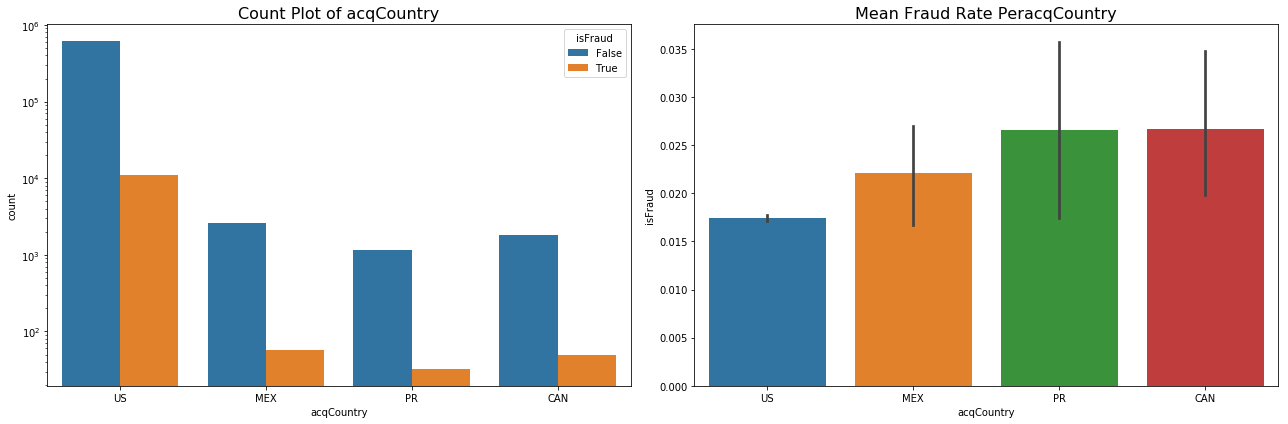

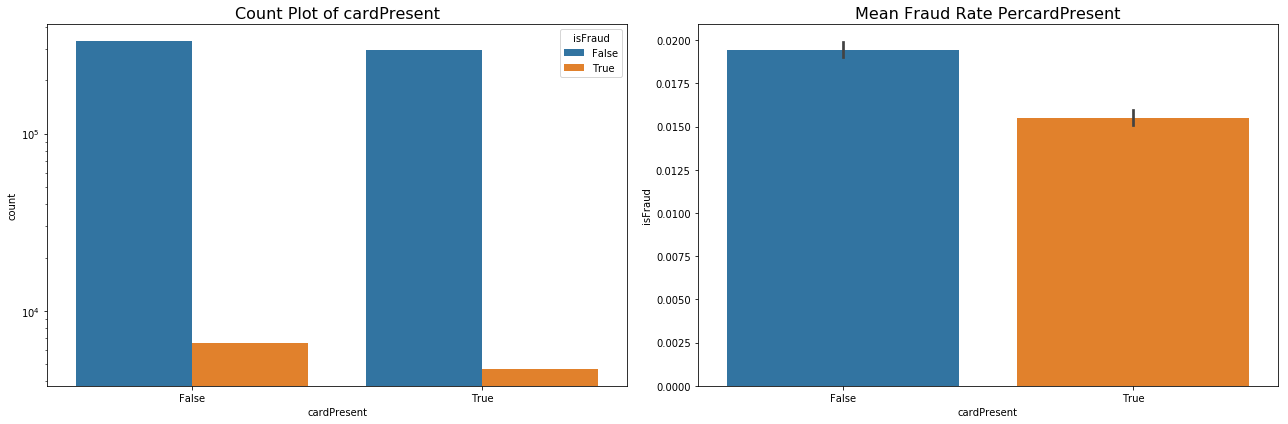

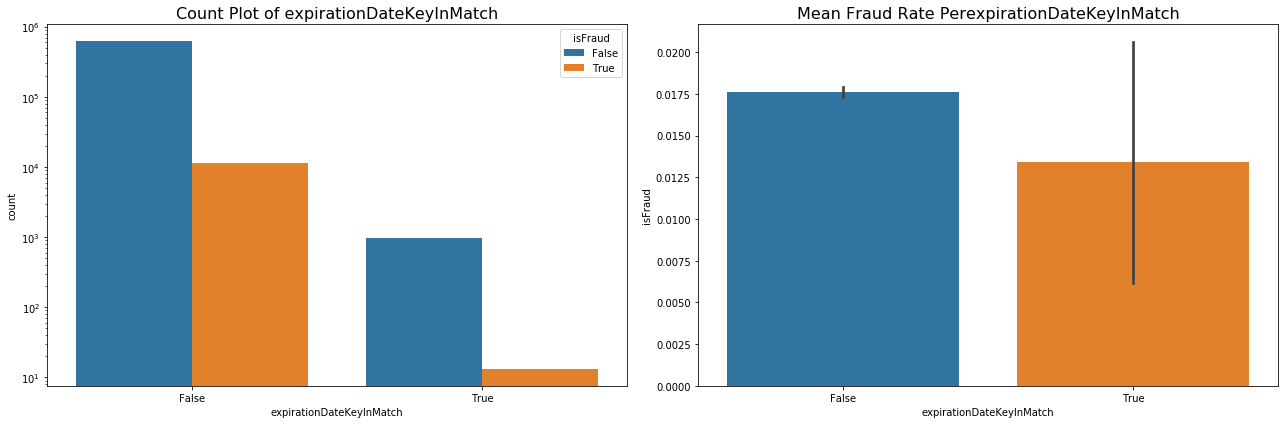

   merchantCategoryCode  fraud rate
11               hotels    0.028410
14        online_retail    0.022586
17            rideshare    0.022245
1                  auto    0.020794
0               airline    0.020621
5                  food    0.020368
13         online_gifts    0.019791
10               health    0.019172
4              fastfood    0.017165
3         entertainment    0.013422



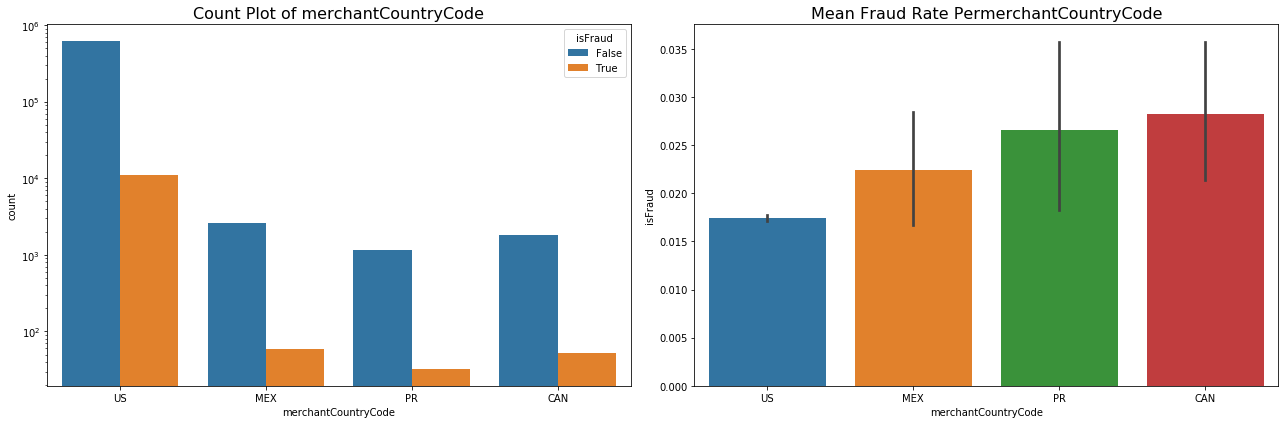

             merchantName  fraud rate
863   Hyatt House #786719    0.195652
860   Hyatt House #691218    0.175926
575           Fast Repair    0.172084
2328    Walgreens #856780    0.157895
858   Hyatt House #686333    0.134146
1181         NYSC #746171    0.130435
1445  Powerlifting #95081    0.129032
859   Hyatt House #687337    0.125000
849   Hyatt House #461673    0.125000
852   Hyatt House #524654    0.125000



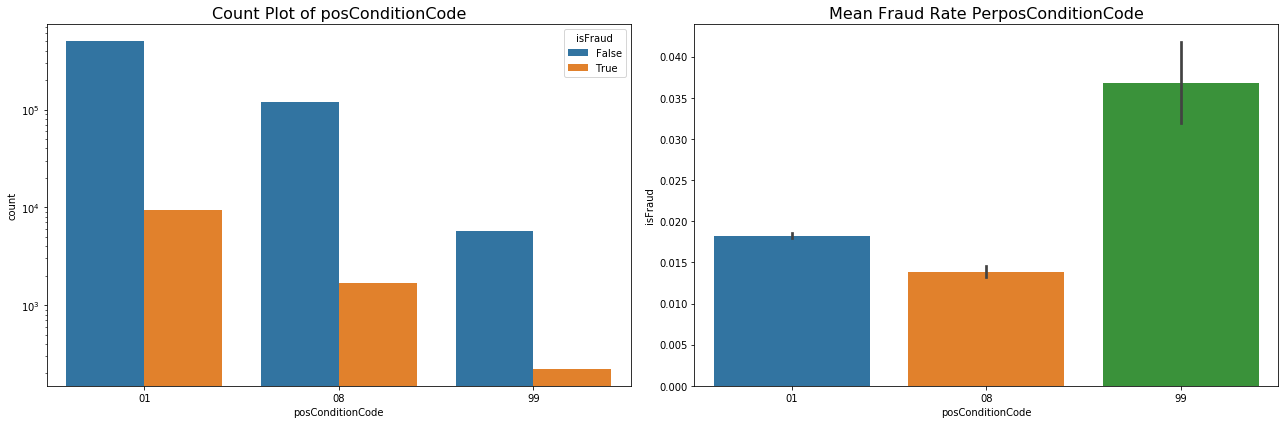

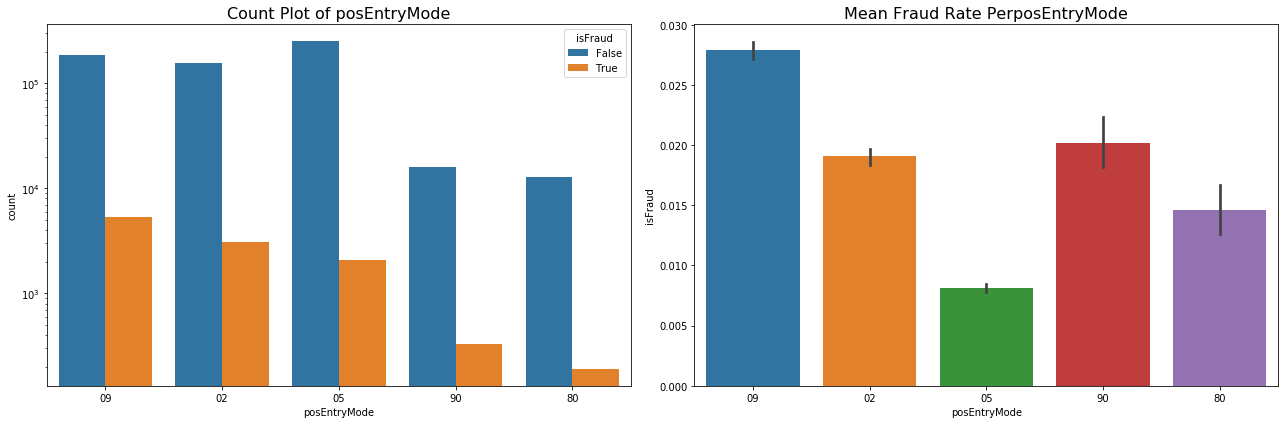

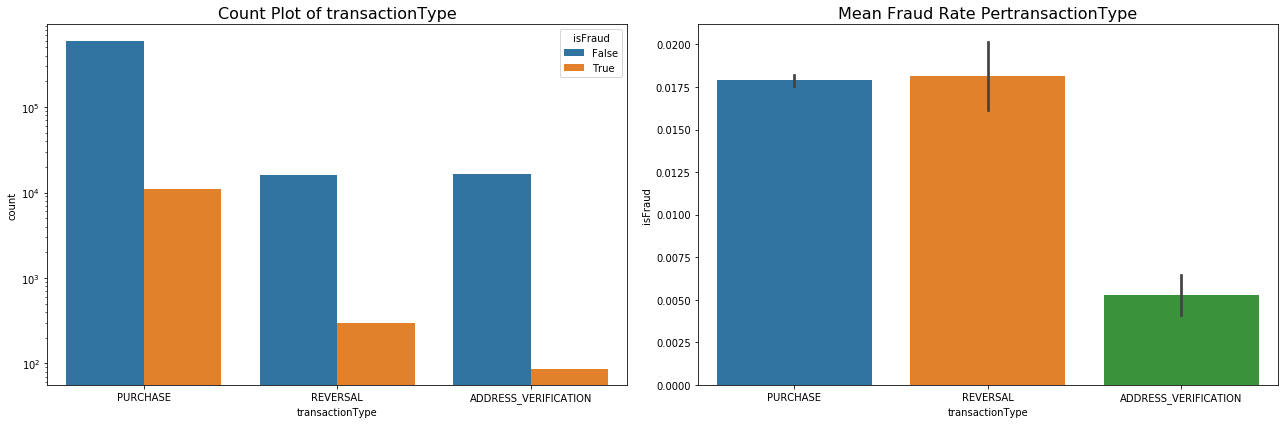

            merchantName_mod  fraud rate
69               Fast Repair    0.172084
85              Hyatt House     0.101999
66               Ethan Allen    0.054054
5                  34th BBQ     0.040661
33              Boston Diner    0.038674
88             John's Bistro    0.038411
40  Convenient Auto Services    0.038241
23              Best Bistro     0.037868
95           Marriott Hotels    0.036697
16         American Airlines    0.036254



In [39]:
# Check to see if any of the categorical or boolean variables is discriminative for the prediction of fraud
vars = [x for x in data.columns if data[x].dtypes in(np.object, np.bool) and x != 'isFraud']

for var in vars:
    num_unique_values = data[var].nunique()
    
    if num_unique_values < 10:
        grouped = data[[var, 'isFraud']].groupby(var).mean().reset_index()

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
        sns.countplot(x=var, hue='isFraud', data=data, ax=ax[0])
        plot_title = 'Count Plot of ' + str(var)
        ax[0].set_title(plot_title, fontsize=16)
        ax[0].set_yscale('log')
        sns.barplot(x = var, y='isFraud', data=data, ax=ax[1])
        plot_title = 'Mean Fraud Rate Per'  + str(var)
        ax[1].set_title(plot_title, fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        grouped = data[[var, 'isFraud']].groupby(var).mean().reset_index()
        grouped.rename(columns = {'isFraud': 'fraud rate'}, inplace = True)
        print(grouped.sort_values(by = 'fraud rate', ascending=False).head(10))
        print()

In [69]:
grouped = data[[var, 'isFraud']].groupby(var).mean().reset_index()
grouped.rename(columns = {'isFraud': 'fraud rate'}, inplace = True)
grouped.sort_values(by = 'fraud rate', ascending=False, inplace = True)

In [74]:
for x in (grouped.head(5)[var]):
    print(x)

Fast Repair
Hyatt House 
Ethan Allen
34th BBQ 
Boston Diner


In [76]:
grouped.shape

(205, 2)

In [ ]:
   merchantCategoryCode  fraud rate
11               hotels    0.028410
14        online_retail    0.022586
17            rideshare    0.022245
1                  auto    0.020794
0               airline    0.020621
5                  food    0.020368
13         online_gifts    0.019791
10               health    0.019172
4              fastfood    0.017165
3         entertainment    0.013422

In [77]:
data[data['merchantName_mod'] == 'Fast Repair'].shape

(523, 30)

In [78]:
data[(data['merchantName_mod'] == 'Fast Repair') & (data['isFraud'] == 1)].shape

(90, 30)

In [79]:
data[(data['merchantName_mod'] == 'Fast Repair') & (data['isFraud'] == 0)].shape

(433, 30)

In [ ]:
            merchantName_mod  fraud rate
69               Fast Repair    0.172084
85              Hyatt House     0.101999
66               Ethan Allen    0.054054
5                  34th BBQ     0.040661
33              Boston Diner    0.038674
88             John's Bistro    0.038411
40  Convenient Auto Services    0.038241
23              Best Bistro     0.037868
95           Marriott Hotels    0.036697
16         American Airlines    0.036254

## Modeling

### 1. Logistic regression

Advantages: simple learner, fast and highly interpretable

In [80]:
def feature_engineer(data):
    # Copy data for modeling purpose
    data1 = data.copy()
    
    #  Change fraud indicator to integer 
    data1['isFraud'] = data1['isFraud'].astype(int)
    # Create card tenure in months variable
    data1['cardTenure'] = (pd.Timestamp.now() - data1['accountOpenDate'])/np.timedelta64(1, 'M')

    # Create new indicator variables
    data1['CVV_ind'] = (data1['enteredCVV'] == data1['cardCVV']).astype(int)
    data1['country_ind'] = (data1['acqCountry'] == data1['merchantCountryCode']).astype(int)

    # Transform categorical variables that have less than 10 unique values to dummy variable
    categoricals = [x for x in data1.columns if data1[x].dtypes == np.object and data1[x].nunique()<10]
    data1 = pd.get_dummies(data1, columns = categoricals, drop_first=True)
    
    # Transform categoricals variables that have more than 9 unique values to dummy variable for those values that are high in fraud rate
    data1['merchantCategoryCode_hotels'] = (data['merchantCategoryCode'] == 'hotels').astype(int)
    data1['merchantCategoryCode_online_retail'] = (data['merchantCategoryCode'] == 'online_retail').astype(int)
    data1['merchantCategoryCode_rideshare'] = (data['merchantCategoryCode'] == 'rideshare').astype(int)
    
    data1['merchantName_mod_Fast_Repair'] = (data['merchantName_mod'] == 'Fast Repair').astype(int)
    data1['merchantName_mod_Hyatt_House'] = (data['merchantName_mod'] == 'Hyatt House').astype(int)
    
    return data1

In [81]:
def upsample(data,  upsample_col):
    '''
    Upsamples the specified column to match the distribution
    
    Input:
        - data: Pandas DataFrame
        - upsample_col: column name which will be upsampled
    
    Output: Pandas DataFrame of which the specified column will be upsampled to have equal distribution, 
        replacement will be used during the upsampling process
    '''
    minority_value = data[upsample_col].value_counts(ascending=True, sort=True).index[0]
    majority_value = data[upsample_col].value_counts(ascending=True, sort=True).index[1]
    
    majority_samples = data[upsample_col].value_counts(ascending=True, sort=True).iloc[1]
    
    data_majority = data[data[upsample_col] == majority_value]
    data_minority = data[data[upsample_col] == minority_value]

    data_minority_upsampled = resample(data_minority, replace=True, n_samples=majority_samples, random_state=123)

    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    
    return data_upsampled

In [116]:
def get_y_X(data, features):
    
    # Split to training and testing set
    train, test = train_test_split(data, random_state=2019)
    
    # Upsample training set
    train_upsampled = upsample(train, 'isFraud')
    
    # Get X and y from training and testing set
    X_train = train_upsampled.loc[:, features]
    y_train = train_upsampled.loc[:,'isFraud']
       
    X_test = test.loc[:, features]
    y_test = test.loc[:,'isFraud']
    
    # Scale data 
    #scaler = MinMaxScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    
    # Normalize data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test

In [117]:
# Preprocess

# Feature engineer
data1 = feature_engineer(data)

# Get training and testing set ready
features = ['availableMoney', 'cardPresent', 'creditLimit', 'currentBalance',
       'expirationDateKeyInMatch', 'transactionAmount', 'reversed', 'multiSwipe', 
       'cardTenure', 'CVV_ind', 'country_ind', 'acqCountry_MEX', 'acqCountry_PR', 'acqCountry_US',
       'merchantCountryCode_MEX', 'merchantCountryCode_PR',
       'merchantCountryCode_US', 'merchantCategoryCode_hotels',
       'merchantCategoryCode_online_retail', 'merchantCategoryCode_rideshare',
       'merchantName_mod_Fast_Repair']
X_train, y_train, X_test, y_test = get_y_X(data1, features)

In [102]:
# Model and performance
lr= LogisticRegression(penalty = 'l1')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


# Model performance
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

Recall: 0.5576182136602452
Precision: 0.034821409042192525


(113497, 44127, 1263, 1592)

In [110]:
lr= LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


# Model performance
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

Recall: 0.5544658493870402
Precision: 0.034913983237759155


(113867, 43757, 1272, 1583)

In [118]:
# with normalization
lr= LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


# Model performance
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

Recall: 0.5572679509632225
Precision: 0.034803342520890755
F1 score: 0.06551504045790524


(113501, 44123, 1264, 1591)

In [111]:
metrics.f1_score(y_test, y_pred)

0.06569146176989314

In [109]:
feature_importances = pd.DataFrame(lr.coef_.T,
                                   index = X_train.columns,
                                    columns=['importance'])
feature_importances.reindex(feature_importances['importance'].abs().sort_values(ascending = False).index)
feature_importances

,importance
availableMoney,-1.994357e-06
cardPresent,-3.703937e-02
creditLimit,-3.087527e-08
currentBalance,7.083936e-06
expirationDateKeyInMatch,-6.032487e-02
transactionAmount,3.798708e-03
reversed,-3.580602e-02
multiSwipe,1.528283e-01
cardTenure,1.115115e-04
CVV_ind,-5.555008e-01


In [93]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(113504, 44120, 1264, 1591)

In [ ]:
def feature_engineer(data):
    attributes = ['accountOpenDate', 'acqCountry', 'availableMoney', 'cardPresent', \
       'creditLimit', 'customerId', 'expirationDateKeyInMatch', 'isFraud', \
       'merchantCategoryCode', 'merchantName', 'posConditionCode', \
       'posEntryMode', 'transactionAmount', 'transactionType', 'time_diff', \
       'multiSwipe']
    data1 = data[attributes]
    
    data1['CVV_ind'] = (data['enteredCVV'] == data['cardCVV']).astype(int)
    
    data1['Country_ind'] = (data['acqCountry'] == data['merchantCountryCode']).astype(int)

    data1['OTB_sign'] = (data['availableMoney'] >= 0).astype(int)

    data1['OTB_ratio'] = data['availableMoney'] / data['creditLimit']
    
    data1['transaction_ratio'] = data['transactionAmount']/ data['availableMoney']
    
    data1 = pd.get_dummies(data1, columns=['acqCountry','cardPresent','expirationDateKeyInMatch',
                                           'transactionType', 'posConditionCode', 'posEntryMode',
                                           'merchantCategoryCode'])
#     m1 = {'cable/phone': '1', 
#          'food_delivery': '1', 
#          'fuel': '1', 
#          'gym': '1',
#          'mobileapps': '1',
#          'online_subscriptions': '1',
#           'airline': '2',
#           'auto': '2',
#           'fastfood': '2',
#           'food': '2',
#           'online_gifts': '2',
#           'health': '2',
#           'online_retail': '2',
#           'rideshare': '2',
#           'hotels': '3',
#           'entertainment': '4',
#           'furniture': '4',
#           'personal care': '4',
#           'subscriptions': '4'
#          }

#     data1['merchantCategoryCode_category'] = data['merchantCategoryCode'].map(m1)
    treshold = 0.04
    mct_data = pd.DataFrame(data.groupby('merchantName').apply(lambda x: sum(x.isFraud == 1) / len(x)))
    mct_data.reset_index(inplace=True)
    mct_data.columns = ['merchantName', 'ratio']


    s1 = set(mct_data.loc[mct_data['ratio'] < 0.000001, 'merchantName'])
    s2 = set(mct_data.loc[(mct_data['ratio'] >= 0.000001)&(mct_data['ratio'] < treshold), 'merchantName'])
    s3 = set(mct_data.loc[mct_data['ratio'] >= treshold, 'merchantName'])

    data1['merchantNameCode'] = 0
    data1.loc[data1['merchantName'].isin(s1), 'merchantNameCode'] = 0
    data1.loc[data1['merchantName'].isin(s2), 'merchantNameCode'] = 1
    data1.loc[data1['merchantName'].isin(s3), 'merchantNameCode'] = 2

    data1.drop('merchantName', axis=1, inplace=True)

    data1['tenure'] = data1['accountOpenDate'].apply(lambda x: 2019 - int(x[:4]))
    data1.drop('accountOpenDate', axis=1, inplace=True)

    data1 = pd.get_dummies(data1, columns=['merchantNameCode'])

    return data1

In [130]:
#  Change fraud indicator to integer 
data['isFraud'] = data['isFraud'].astype(int)

In [93]:
# Transform categorical variables to dummy variables for modeling
categoricals = [x for x in data.columns if data[x].dtypes == np.object and data[x].nunique()<10]
data = pd.get_dummies(data, columns = categoricals, drop_first=True )

In [94]:
data.columns

Index(['accountNumber', 'accountOpenDate', 'availableMoney', 'cardCVV',
       'cardLast4Digits', 'cardPresent', 'creditLimit', 'currentBalance',
       'currentExpDate', 'customerId', 'dateOfLastAddressChange', 'echoBuffer',
       'enteredCVV', 'expirationDateKeyInMatch', 'isFraud',
       'merchantCategoryCode', 'merchantCity', 'merchantName', 'merchantState',
       'merchantZip', 'posOnPremises', 'recurringAuthInd', 'transactionAmount',
       'transactionDateTime', 'cardTenure', 'acqCountry_MEX', 'acqCountry_PR',
       'acqCountry_US', 'merchantCountryCode_MEX', 'merchantCountryCode_PR',
       'merchantCountryCode_US', 'posConditionCode_08', 'posConditionCode_99',
       'posEntryMode_05', 'posEntryMode_09', 'posEntryMode_80',
       'posEntryMode_90', 'transactionType_PURCHASE',
       'transactionType_REVERSAL'],
      dtype='object')

In [95]:
X = data.loc[:, data.columns!= 'isFraud']
y = data.loc[:,'isFraud']

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)

In [159]:
data.columns

Index(['accountNumber', 'accountOpenDate', 'acqCountry', 'availableMoney',
       'cardCVV', 'cardLast4Digits', 'cardPresent', 'creditLimit',
       'currentBalance', 'currentExpDate', 'customerId',
       'dateOfLastAddressChange', 'enteredCVV', 'expirationDateKeyInMatch',
       'isFraud', 'merchantCategoryCode', 'merchantCountryCode',
       'merchantName', 'posConditionCode', 'posEntryMode', 'transactionAmount',
       'transactionDateTime', 'transactionType', 'time_diff', 'multiSwipe'],
      dtype='object')

In [102]:
attributes = ['accountNumber', 'availableMoney', 
        'cardPresent', 'creditLimit', 'currentBalance',
        'customerId', 'expirationDateKeyInMatch', 'recurringAuthInd', 'transactionAmount',
        'cardTenure', 'acqCountry_MEX', 'acqCountry_PR',
       'acqCountry_US', 'merchantCountryCode_MEX', 'merchantCountryCode_PR',
       'merchantCountryCode_US', 'posConditionCode_08', 'posConditionCode_99',
       'posEntryMode_05', 'posEntryMode_09', 'posEntryMode_80',
       'posEntryMode_90', 'transactionType_PURCHASE',
       'transactionType_REVERSAL']
clf = RandomForestClassifier()
y_pred = clf.fit(X_train[attributes], y_train).predict_prob(X_test[attributes])

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').